_Lambda School Data Science, Unit 2_

---

👇 **Do not change the code in this cell.** If you're working in Google Colab, you can run this cell to install `category_encoders`.

In [233]:
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders

In [234]:
def color_percent(floaty):
  "Input a normalized number between 0 and 1, and get it in string form colored according to percentage."
  if floaty >= .5:
    green = 200
    red = int(500 * (1 - floaty))
  else:
    red = 255
    green = int(400 * floaty)

  return f'\033[38;2;{red};{green};0m{floaty}\033[00m'

 
# Sprint Challenge: Predict Steph Curry's Shots 🏀

For your Sprint Challenge, you'll use a dataset with all Steph Curry's NBA field goal attempts from October 2009 through June 2019 (regular season and playoffs). The dataset was collected with the [nba_api](https://github.com/swar/nba_api) Python library.

You'll create a model to predict whether Curry will make a shot based on his past perfomance.

# Directions

This notebook contains 10 tasks, which cover the material we've learned in this sprint. Here's a summary:

- **Task 1:** Importing data.
- **Task 2:** Feature engineering.
- **Task 3:** Splitting data into a feature matrix and target vector.
- **Task 4:** Splitting data into training, validation, and test sets.
- **Task 5:** Establishing baseline accuracy.
- **Task 6:** Building a model with a transformer and a tree-based predictor.
- **Task 7:** Calculating training and validation accuracy.
- **Task 8 (`stretch goal`):** Tuning model hyperparameters.
- **Task 9:** Calculating precision and recall from a confusion matrix.
- **Task 10 (`stretch goal`):** Plotting a confusion matrix.

For each task you should do the following:

- Read the task instructions.
- Write your code in the cell below the task. Delete the `raise 
NotImplementedError` before your start.
- Run the testing cell below the task. If you get an error, read the error message and re-evaluate your code.

**You should limit your code to the following libraries:**

- `category_encoders`
- `numpy`
- `matplotlib`
- `pandas`
- `sklearn`



# I. Wrangle Data

**Task 1:** Change the code below to import your dataset. Be sure to examine the columns carefully and determine if one of them should be set at the index. 

In [235]:
'''T1. Import DataFrame `df`'''

import pandas as pd
url = 'https://drive.google.com/uc?export=download&id=1fL7KPyxgGYfQDsuJoBWHIWwCAf-HTFpX'
df = pd.read_csv(url, index_col='game_date', parse_dates=['game_date'])
# YOUR CODE HERE

print(df.shape, '\n')
for col in df.columns:
  print(col, df[col].nunique())

df.head()

(13958, 19) 

game_id 801
game_event_id 713
player_name 1
period 6
minutes_remaining 12
seconds_remaining 60
action_type 53
shot_type 2
shot_zone_basic 7
shot_zone_area 6
shot_zone_range 5
shot_distance 73
loc_x 493
loc_y 458
shot_made_flag 2
htm 32
vtm 32
season_type 2
scoremargin_before_shot 79


,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,htm,vtm,season_type,scoremargin_before_shot
game_date,,,,,,,,,,,,,,,,,,,
2009-10-28,20900015,4,Stephen Curry,1,11,25,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26,99,249,0,GSW,HOU,Regular Season,2.0
2009-10-28,20900015,17,Stephen Curry,1,9,31,Step Back Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-122,145,1,GSW,HOU,Regular Season,0.0
2009-10-28,20900015,53,Stephen Curry,1,6,2,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,14,-60,129,0,GSW,HOU,Regular Season,-4.0
2009-10-28,20900015,141,Stephen Curry,2,9,49,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),16-24 ft.,19,-172,82,0,GSW,HOU,Regular Season,-4.0
2009-10-28,20900015,249,Stephen Curry,2,2,19,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-68,148,0,GSW,HOU,Regular Season,0.0


In [236]:
type(df.index)

pandas.core.indexes.datetimes.DatetimeIndex

**Task 1 Testing**

In [237]:
'''T1 Testing'''

assert isinstance(df, pd.DataFrame), 'Have you created a DataFrame named `df`?'
assert len(df) == 13958, 'Is `df` the correct length?'


**Task 2a:** Engineer at least 1 new feature. You can use something from the list below or your own idea.

- **Homecourt Advantage**: Is the home team (`htm`) the Golden State Warriors (`GSW`) ?
- **Opponent**: Who is the other team playing the Golden State Warriors?
- **Seconds remaining in the period**: Combine minutes remaining with seconds remaining, to get the total number of seconds remaining in the period.
- **Seconds remaining in the game**: Combine period, and seconds remaining in the period, to get the total number of seconds remaining in the game. A basketball game has 4 periods, each 12 minutes long.
- **Made previous shot**: Was Steph Curry's previous shot successful?

**Task 2b (`stretch goal — optional`):** Create a total of 3 new features, using your own ideas or the list above. Make sure you're not just duplicating features that are already in the feature matrix.

In [238]:
import numpy as np

In [239]:
"""T2. Create new feature"""

# YOUR CODE HERE
df['seconds_period_remaining'] = (df['minutes_remaining'] * 60) + df['seconds_remaining']
df['home_advantage'] = np.where(df['htm'] == 'GSW', 1, 0)
df['seconds_remaining_game'] = ((df['period']-1)*12*60)+(df['minutes_remaining']*60)+df['seconds_remaining']

# df = df.drop(columns=['minutes_remaining', 'seconds_remaining'])

In [240]:
df.head()

,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,htm,vtm,season_type,scoremargin_before_shot,seconds_period_remaining,home_advantage,seconds_remaining_game
game_date,,,,,,,,,,,,,,,,,,,,,,
2009-10-28,20900015,4,Stephen Curry,1,11,25,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26,99,249,0,GSW,HOU,Regular Season,2.0,685,1,685
2009-10-28,20900015,17,Stephen Curry,1,9,31,Step Back Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-122,145,1,GSW,HOU,Regular Season,0.0,571,1,571
2009-10-28,20900015,53,Stephen Curry,1,6,2,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,14,-60,129,0,GSW,HOU,Regular Season,-4.0,362,1,362
2009-10-28,20900015,141,Stephen Curry,2,9,49,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),16-24 ft.,19,-172,82,0,GSW,HOU,Regular Season,-4.0,589,1,1309
2009-10-28,20900015,249,Stephen Curry,2,2,19,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-68,148,0,GSW,HOU,Regular Season,0.0,139,1,859


**Task 2 Test**

In [241]:
'''T2 Testing'''

assert df.shape[1] >= 20, '`df` does not appear to have new features.'


# II. Split Data

**Task 3:** Divide the DataFrame `df` into the feature matrix `X` and the target vector `y`. Your target is `'shot_made_flag'`.

In [242]:
# Drop HCCCs
cutoff = 100
drop_cols = [col for col in df.select_dtypes('object').columns
            if df[col].nunique() > cutoff]
df = df.drop(columns=drop_cols)

In [243]:
'''T3. Create `X` and `y`.'''
# YOUR CODE HERE
target = 'shot_made_flag'
X = df.drop(target, axis=1)
y = df[target]

**Task 3 Test**

In [244]:
'''T3 Tests'''

assert y.shape == (13958,), '`y` either has the wrong number of rows, or is two-dimentional.'
assert len(X) == 13958, '`X` has the wrong number of rows.'
assert X.shape[1] > 1, '`X` has the wrong number of columns'
assert 'shot_made_flag' not in X.columns, 'Target is still part of feature matrix.' 

**Task 4:** Divide your dataset into training, validation, and test sets. 

- Your training set (`X_train`, `y_train`) should contain games from the 2009-10 season through the end of the 2016-17 season.
- Your validation set (`X_val`, `y_val`) should contain games from the 2017-18 season.
- Your test set (`X_test`, `y_test`) should contain games from the 2018-2019 season.
- **Tip:** The NBA season begins in October and ends in June.

In [245]:
'''T4. Create training and val'''
# YOUR CODE HERE
begin = '2009-08-15'
mid = '2017-08-15'
mid2 = '2018-08-15'
end = '2019-08-15'

mask = lambda start, close : (X.index > start) & (df.index < close)

X_train, y_train = X.loc[mask(begin, mid)], y.loc[mask(begin, mid)]
X_val, y_val = X.loc[mask(mid, mid2)], y.loc[mask(mid, mid2)]
X_test, y_test = X.loc[mask(mid2, end)], y.loc[mask(mid2, end)]

**Test 4**

In [246]:
'''T4 Tests'''
assert len(X_train) == len(y_train) == 11081
assert len(X_val) == len(y_val) == 1168
assert len(X_test) == len(y_test) == 1709


# III. Establish Baseline

**Task 5:** Establish the baseline accuracy score for this classification problem using your training set. Save the score to the variable `baseline_acc`.

In [247]:
from sklearn.metrics import mean_absolute_error

In [248]:
'''T5. Calculate baseline accuracy `baseline_acc`.'''

# YOUR CODE HERE
baseline_acc = y_train.value_counts(normalize=True).max()

print('Baseline Accuracy:', color_percent(baseline_acc))

Baseline Accuracy: 0.5272087356736757


**Task 5 Testing**

In [249]:
'''T5 Testing'''

assert isinstance(baseline_acc, float)
assert 0.0 <= baseline_acc <= 1.0


# IV. Build Model

**Task 6:** Build a model that includes (1) a transformer for categorical features and (2) a tree-based predictor. You should combine these two components (and any other pieces you think are necessary) in a pipeline named `model`. Be sure to fit your model to your training data.

In [250]:
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier

In [251]:
'''T6. Build a pipeline `model` with encoder and tree-based predictor.'''

# YOUR CODE HERE
model = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    RandomForestClassifier(
        n_jobs=-1,
        max_depth=7,
        n_estimators=34
    )
)
model.fit(X_train, y_train)

train_acc = model.score(X_train, y_train)
val_acc = accuracy_score(y_val, model.predict(X_val))

print('Training Accuracy Score:', color_percent(train_acc))
print('Validation Accuracy Score:', color_percent(val_acc))

Training Accuracy Score: 0.6916343290316759
Validation Accuracy Score: 0.610445205479452


In [252]:
listy = []
for x in range(6, 14, 1):
  model = make_pipeline(
      OrdinalEncoder(),
      SimpleImputer(strategy='mean'),
      RandomForestClassifier(
          n_jobs=-1,
          max_depth=x,
          n_estimators=34
      )
  )
  model.fit(X_train, y_train)

  val_acc = accuracy_score(y_val, model.predict(X_val))
  listy.append((x, val_acc))

key = lambda e : e[1]

listy.sort(key=key)

listy[-1]

(9, 0.6181506849315068)

**Task 6 Testing**

In [253]:
'''T6 Testing'''

from sklearn.pipeline import Pipeline
assert isinstance(model, Pipeline), '`model` should be type `Pipeline`.'

# Does `model` Pipeline have multiple components?
assert len(model.named_steps.keys()) > 1, '`model` should have more than one component.'

# Has `model` been trained?
assert hasattr(model, 'classes_'), 'Have you trained `model`?'


# V. Check Metrics

**Task 7:** Check the training and validation accuracy of your model, and assign the scores to `train_acc` and `val_acc` respectively.

In [254]:
from sklearn.metrics import accuracy_score

In [255]:
'''T7. Calculate train and test accuracy.'''

# YOUR CODE HERE
train_acc = model.score(X_train, y_train)
val_acc = accuracy_score(y_val, model.predict(X_val))

print('Training Accuracy Score:', color_percent(train_acc))
print('Validation Accuracy Score:', color_percent(val_acc))

Training Accuracy Score: 0.8474866889269922
Validation Accuracy Score: 0.5993150684931506


**Task 7 Test**

In [256]:
'''T7 Testing'''

# Is `training_acc` a float between 0.0 and 1.0?
assert isinstance(train_acc, float)
assert 0.0 <= train_acc <= 1.0

# Is `validation_acc` a float between 0.0 and 1.0?
assert isinstance(val_acc, float)
assert 0.0 <= val_acc <= 1.0


# VI. Tune Model

**Task 8 (`stretch goal — optional`):** Using your training and validation sets as a guide, tune the hyperparameters of your model to see if you can improve its accuracy. You can perform your tuning "by hand" or using [`RandomizedSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html).

- Important hyperparameters for all tree-based models: `max_depth`.
- Important hyperparameters for random forest models: `n_estimators`, `max_samples`. 
- Important hyperparametes for gradient boosting tree models: `n_estimators`, `learning_rate`.
- **TIP:** If you use `RandomizedSearchCV`, set `n_iter` to `3`. Any larger and the auto-grader will stop working.
- **TIP:** Since you already created a validation set above, there is no need to do k-fold cross-validation here. Set `cv` to `None`.

Once you're satisfied with your model's performance on the validation set (if you can get above `0.6`, you're doing good), calculate its accuracy with your test set. Assign the result to `test_acc`.

In [257]:
'''T8. Tune model.'''

# YOUR CODE HERE
test_acc = model.score(X_test, y_test)

print('Testing Accuracy Score:', color_percent(test_acc))

Testing Accuracy Score: 0.6138092451726156


**Task 8 Testing**

In [258]:
'''T8 Testing'''
assert isinstance(test_acc, float)
assert 0.0 <= test_acc <= 1.0

# VII. Communication

**Task 9:** Below is a confusion matrix for the model that your instructor made for this challenge (based on the **test data**). Calculate the precision and recall of this model, naming them `instructor_precision` and `instructor_recall`, respectively.

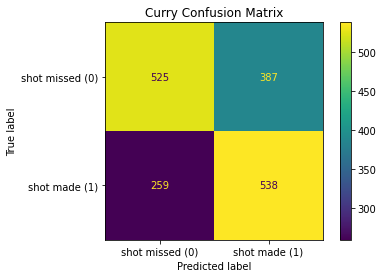

In [259]:
from sklearn.metrics import plot_confusion_matrix

In [260]:
'''T9. Calculate precision and recall'''
# YOUR CODE HERE
# plot_confusion_matrix(model, X_val, y_val, values_format='.0f')

instructor_precision = 538 / (538 + 387)
instructor_recall = 538 / (538 + 259)

print('Instuctor model precision', color_percent(instructor_precision))
print('Instuctor model recall', color_percent(instructor_recall))

Instuctor model precision 0.5816216216216217
Instuctor model recall 0.6750313676286073


**Task 9 Testing**

In [261]:
'''T9 Testing'''
assert isinstance(instructor_precision, float)
assert isinstance(instructor_recall, float)
assert 0 <= instructor_precision <= 1
assert 0 <= instructor_recall <= 1

**Task 10 (`stretch goal — optional`):** Plot confusion matrix for your model using your **test data**. Does your model have higher recall or higher precision? How does your model's metrics compare to the metrics you calculated above?

Instuctor model precision 0.5618115055079559
Instuctor model recall 0.5759096612296111


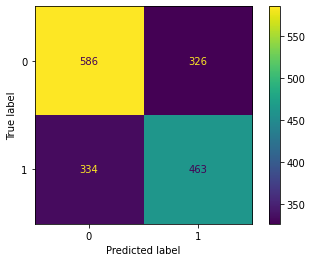

In [262]:
'''T10. Plot ROC curve.'''
# YOUR CODE HERE
plot_confusion_matrix(model, X_test, y_test, values_format='.0f')

instructor_precision = 459 / (459 + 358)
instructor_recall = 459 / (459 + 338)

print('Instuctor model precision', color_percent(instructor_precision))
print('Instuctor model recall', color_percent(instructor_recall))